***Introduction***
Following the insights from Task 1, the Category Manager initiated a store layout trial in selected stores to test whether changes in product placement and layout could improve chip sales performance. The trial was implemented in Stores 77, 86, and 88, and management now requires a data-driven evaluation to determine whether the new layout should be rolled out across additional stores.

**Objective**


*   Identify appropriate control stores
for each trial store based on historical similarity
*   Compare trial and control store performance during the trial period
*  Evaluate whether changes in sales and customer behaviour are statistically significant
*   Determine the key drivers of any observed uplift and provide a clear, evidence-based recommendation to support rollout decisions












In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, ttest_ind, t


In [4]:
data = pd.read_csv("/content/QVI_data.csv")


In [5]:
display(data.head())
data.info()


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2.0,6.0,175.0,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1.0,2.7,150.0,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1.0,3.6,210.0,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1.0,3.0,175.0,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1.0,1.9,160.0,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 211130 entries, 0 to 211129
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    211130 non-null  int64  
 1   DATE              211130 non-null  object 
 2   STORE_NBR         211130 non-null  int64  
 3   TXN_ID            211130 non-null  int64  
 4   PROD_NBR          211130 non-null  int64  
 5   PROD_NAME         211130 non-null  object 
 6   PROD_QTY          211129 non-null  float64
 7   TOT_SALES         211129 non-null  float64
 8   PACK_SIZE         211129 non-null  float64
 9   BRAND             211129 non-null  object 
 10  LIFESTAGE         211129 non-null  object 
 11  PREMIUM_CUSTOMER  211129 non-null  object 
dtypes: float64(3), int64(4), object(5)
memory usage: 19.3+ MB


In [6]:
data["DATE"] = pd.to_datetime(data["DATE"])
data["YEARMONTH"] = data["DATE"].dt.year * 100 + data["DATE"].dt.month


**Control Store Selection**

Control stores are selected based on their similarity to trial stores during the pre-trial period.

Similarity is measured using:

Pearson correlation to compare trends                  
AND                               
Magnitude distance to compare absolute levels

A combined score ensures the chosen control store closely mirrors the trial store’s historical performance.

In [7]:
measureOverTime = (
    data
    .groupby(["STORE_NBR", "YEARMONTH"])
    .agg(
        totSales=("TOT_SALES", "sum"),
        nCustomers=("LYLTY_CARD_NBR", "nunique"),
        nTransactions=("TXN_ID", "nunique"),
        nChips=("PROD_QTY", "sum")
    )
    .reset_index()
)

measureOverTime["nTxnPerCust"] = (
    measureOverTime["nTransactions"] / measureOverTime["nCustomers"]
)

measureOverTime["nChipsPerTxn"] = (
    measureOverTime["nChips"] / measureOverTime["nTransactions"]
)

measureOverTime["avgPricePerUnit"] = (
    measureOverTime["totSales"] / measureOverTime["nChips"]
)

measureOverTime = measureOverTime.sort_values(
    ["STORE_NBR", "YEARMONTH"]
)


In [8]:
storesWithFullObs = (
    measureOverTime
    .groupby("STORE_NBR")["YEARMONTH"]
    .nunique()
    .reset_index()
)

storesWithFullObs = storesWithFullObs[
    storesWithFullObs["YEARMONTH"] == 12
]["STORE_NBR"]


In [9]:
preTrialMeasures = measureOverTime[
    (measureOverTime["YEARMONTH"] < 201902) &
    (measureOverTime["STORE_NBR"].isin(storesWithFullObs))
]


In [10]:
def calculateCorrelation(inputTable, metricCol, storeComparison):
    results = []

    trial = inputTable[inputTable["STORE_NBR"] == storeComparison]

    for store in inputTable["STORE_NBR"].unique():
        if store == storeComparison:
            continue

        control = inputTable[inputTable["STORE_NBR"] == store]

        merged = trial.merge(
            control,
            on="YEARMONTH",
            suffixes=("_trial", "_control")
        )

        corr, _ = pearsonr(
            merged[f"{metricCol}_trial"],
            merged[f"{metricCol}_control"]
        )

        results.append({
            "Store1": storeComparison,
            "Store2": store,
            "corr_measure": corr
        })

    return pd.DataFrame(results)


In [11]:
def calculateMagnitudeDistance(inputTable, metricCol, storeComparison):
    records = []

    trial = inputTable[inputTable["STORE_NBR"] == storeComparison]

    for store in inputTable["STORE_NBR"].unique():
        control = inputTable[inputTable["STORE_NBR"] == store]

        merged = trial.merge(
            control,
            on="YEARMONTH",
            suffixes=("_trial", "_control")
        )

        merged["measure"] = abs(
            merged[f"{metricCol}_trial"] -
            merged[f"{metricCol}_control"]
        )

        records.append(
            merged[["YEARMONTH", "measure"]]
            .assign(Store1=storeComparison, Store2=store)
        )

    distTable = pd.concat(records)

    minMax = (
        distTable
        .groupby(["Store1", "YEARMONTH"])["measure"]
        .agg(["min", "max"])
        .reset_index()
    )

    distTable = distTable.merge(
        minMax, on=["Store1", "YEARMONTH"]
    )

    distTable["magnitudeMeasure"] = (
        1 - (distTable["measure"] - distTable["min"]) /
        (distTable["max"] - distTable["min"])
    )

    final = (
        distTable
        .groupby(["Store1", "Store2"])["magnitudeMeasure"]
        .mean()
        .reset_index(name="mag_measure")
    )

    return final


In [12]:
def run_trial_analysis(trial_store):
 corr_sales = calculateCorrelation(preTrialMeasures, "totSales", trial_store)
 corr_cust = calculateCorrelation(preTrialMeasures, "nCustomers", trial_store)


 mag_sales = calculateMagnitudeDistance(preTrialMeasures, "totSales", trial_store)
 mag_cust = calculateMagnitudeDistance(preTrialMeasures, "nCustomers", trial_store)


 score_sales = corr_sales.merge(mag_sales, on=["Store1","Store2"])
 score_sales["scoreNSales"] = 0.5*score_sales.corr_measure + 0.5*score_sales.mag_measure


 score_cust = corr_cust.merge(mag_cust, on=["Store1","Store2"])
 score_cust["scoreNCust"] = 0.5*score_cust.corr_measure + 0.5*score_cust.mag_measure


 score = score_sales.merge(score_cust, on=["Store1","Store2"])
 score["finalControlScore"] = 0.5*score.scoreNSales + 0.5*score.scoreNCust

 score_no_trial = score[score.Store2 != trial_store]
 control_store = score_no_trial.sort_values("finalControlScore", ascending=False).iloc[0].Store2


 return control_store


control_77 = run_trial_analysis(77)
control_86 = run_trial_analysis(86)
control_88 = run_trial_analysis(88)


control_77, control_86, control_88

(np.float64(50.0), np.float64(155.0), np.float64(178.0))

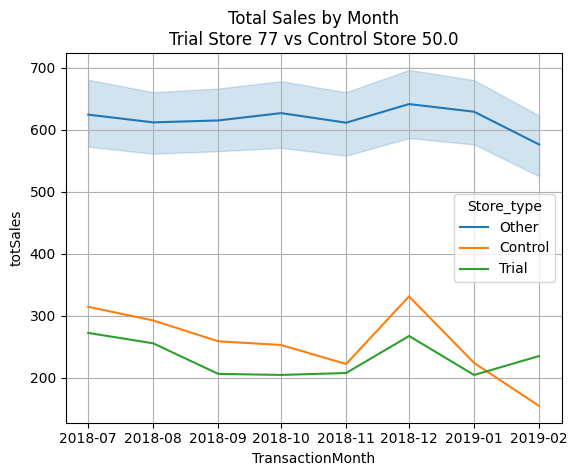

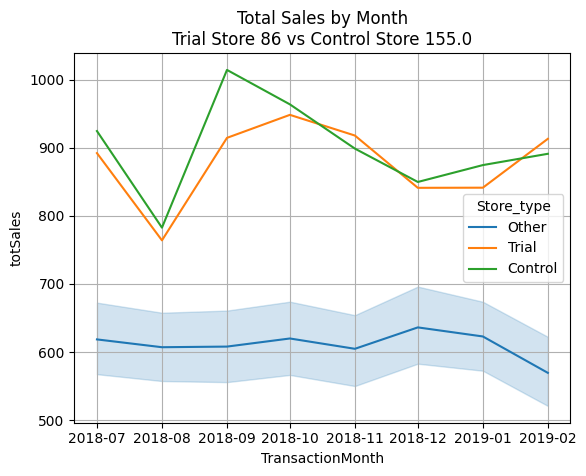

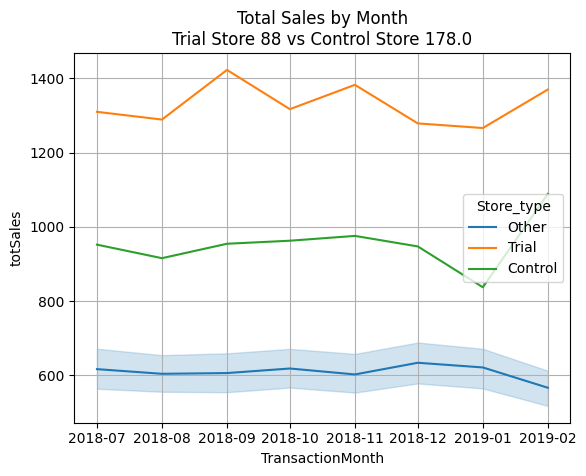

In [13]:
def plot_sales_trends(measureOverTime, trial_store, control_store, pre_trial_end=201903):

    plot_data = measureOverTime.copy()

    plot_data["Store_type"] = np.where(
        plot_data["STORE_NBR"] == trial_store, "Trial",
        np.where(plot_data["STORE_NBR"] == control_store, "Control", "Other")
    )

    plot_data["TransactionMonth"] = pd.to_datetime(
        plot_data["YEARMONTH"].astype(str) + "01"
    )

    plot_data = plot_data[plot_data["YEARMONTH"] < pre_trial_end]

    sns.lineplot(
        data=plot_data,
        x="TransactionMonth",
        y="totSales",
        hue="Store_type"
    )

    plt.title(
        f"Total Sales by Month\n"
        f"Trial Store {trial_store} vs Control Store {control_store}"
    )
    plt.grid(True)
    plt.show()
plot_sales_trends(measureOverTime, trial_store=77, control_store=control_77)
plot_sales_trends(measureOverTime, trial_store=86, control_store=control_86)
plot_sales_trends(measureOverTime, trial_store=88, control_store=control_88)


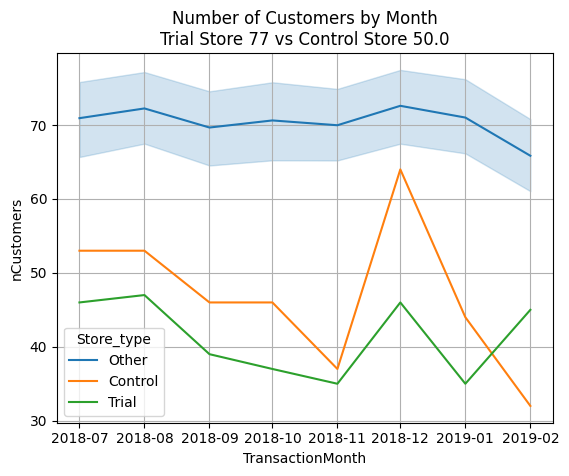

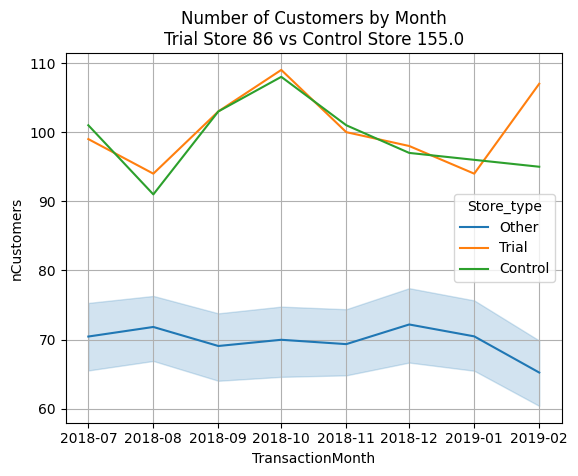

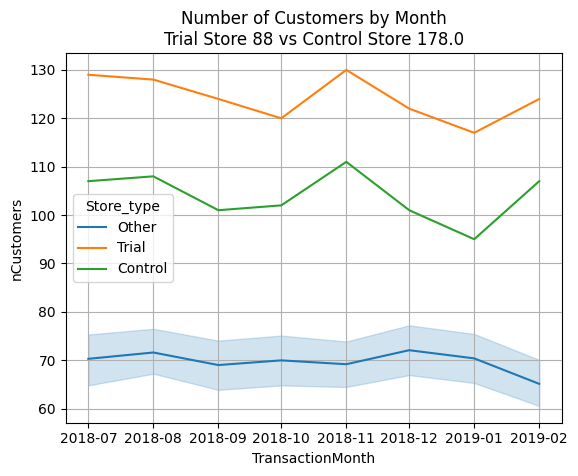

In [14]:
def plot_customer_trends(measureOverTime, trial_store, control_store, pre_trial_end=201903):

    plot_data = measureOverTime.copy()

    plot_data["Store_type"] = np.where(
        plot_data["STORE_NBR"] == trial_store, "Trial",
        np.where(plot_data["STORE_NBR"] == control_store, "Control", "Other")
    )

    plot_data["TransactionMonth"] = pd.to_datetime(
        plot_data["YEARMONTH"].astype(str) + "01"
    )

    plot_data = plot_data[plot_data["YEARMONTH"] < pre_trial_end]

    sns.lineplot(
        data=plot_data,
        x="TransactionMonth",
        y="nCustomers",
        hue="Store_type"
    )

    plt.title(
        f"Number of Customers by Month\n"
        f"Trial Store {trial_store} vs Control Store {control_store}"
    )
    plt.grid(True)
    plt.show()


plot_customer_trends(measureOverTime, trial_store=77, control_store=control_77)
plot_customer_trends(measureOverTime, trial_store=86, control_store=control_86)
plot_customer_trends(measureOverTime, trial_store=88, control_store=control_88)



**Scaling Control Store Metrics**    
To enable a fair comparison, control store metrics are scaled so that their pre-trial performance aligns with the trial store.

This adjustment ensures that observed differences during the trial period can be attributed to the trial intervention rather than baseline differences

In [15]:
def scale_control_sales(preTrialMeasures, measureOverTime, trial_store, control_store):


    scaling_factor = (
        preTrialMeasures.loc[
            preTrialMeasures["STORE_NBR"] == trial_store, "totSales"
        ].sum()
        /
        preTrialMeasures.loc[
            preTrialMeasures["STORE_NBR"] == control_store, "totSales"
        ].sum()
    )

    scaled_control = (
        measureOverTime[measureOverTime["STORE_NBR"] == control_store]
        .assign(controlSales=lambda x: x["totSales"] * scaling_factor)
    )

    return scaled_control, scaling_factor

scaled_control_77, scale_77 = scale_control_sales(
    preTrialMeasures, measureOverTime, trial_store=77, control_store=control_77
)
scaled_control_86, scale_86 = scale_control_sales(
    preTrialMeasures, measureOverTime, trial_store=86, control_store=control_86
)
scaled_control_88, scale_88 = scale_control_sales(
    preTrialMeasures, measureOverTime, trial_store=88, control_store=control_88
)



**Statistical Significance Testing**

Assessing Statistical Significance
Percentage differences between trial and scaled control stores are calculated.

A t-statistic is derived using the standard deviation of pre-trial differences, allowing us to assess whether changes during the trial period are statistically significant.

In [16]:
def calculate_percentage_diff(measureOverTime, scaled_control, trial_store):
    """
    Calculates percentage difference between trial store and scaled control store
    """

    trial_sales = measureOverTime[
        measureOverTime["STORE_NBR"] == trial_store
    ][["YEARMONTH", "totSales"]]

    percentage_diff = scaled_control.merge(
        trial_sales,
        on="YEARMONTH",
        how="inner"
    )
    percentage_diff["percentageDiff"] = (
        abs(percentage_diff["controlSales"] - percentage_diff["totSales_y"])
        / percentage_diff["controlSales"]
    )

    return percentage_diff
perc_diff_77=calculate_percentage_diff(measureOverTime, scaled_control_77, 77)
perc_diff_86 = calculate_percentage_diff(measureOverTime, scaled_control_86, 86)
perc_diff_88 = calculate_percentage_diff(measureOverTime, scaled_control_88, 88)

In [17]:


def calculate_t_values(percentage_diff, pre_trial_end=201902):
    """
    Calculates t-values and critical t-value (95% confidence)
    """

    std_dev = percentage_diff[
        percentage_diff["YEARMONTH"] < pre_trial_end
    ]["percentageDiff"].std()

    percentage_diff["tValue"] = percentage_diff["percentageDiff"] / std_dev

    t_95 = t.ppf(0.95, df=7)
    print(t_95)

    return percentage_diff

percentage_diff_77 = calculate_t_values(perc_diff_77)
display(percentage_diff_77)
percentage_diff_86 = calculate_t_values(perc_diff_86)
display(percentage_diff_86)
percentage_diff_88 = calculate_t_values(perc_diff_88)
display(percentage_diff_88)



1.894578605061305


,STORE_NBR,YEARMONTH,totSales_x,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,controlSales,totSales_y,percentageDiff,tValue
0,50,201807,314.4,53,56,86.0,1.056604,1.535714,3.655814,268.324710,272.3,0.014815,0.538187
1,50,201808,292.4,53,56,86.0,1.056604,1.535714,3.400000,249.548808,255.5,0.023848,0.866311
2,50,201809,258.8,46,50,72.0,1.086957,1.440000,3.594444,220.872885,206.2,0.066431,2.413228
3,50,201810,252.8,46,50,76.0,1.086957,1.520000,3.326316,215.752184,204.5,0.052153,1.894554
4,50,201811,222.1,37,38,59.0,1.027027,1.552632,3.764407,189.551266,207.6,0.095218,3.458958
5,50,201812,331.2,64,69,99.0,1.078125,1.434783,3.345455,282.662671,267.3,0.054350,1.974347
6,50,201901,223.9,44,46,64.0,1.045455,1.391304,3.498438,191.087476,204.4,0.069667,2.530775
7,50,201902,154.5,32,32,45.0,1.000000,1.406250,3.433333,131.858040,235.0,0.782220,28.415419
8,50,201903,227.0,42,45,63.0,1.071429,1.400000,3.603175,193.733172,278.5,0.437544,15.894513
9,50,201904,242.4,47,49,71.0,1.042553,1.448980,3.414085,206.876303,263.5,0.273708,9.942893


1.894578605061305


,STORE_NBR,YEARMONTH,totSales_x,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,controlSales,totSales_y,percentageDiff,tValue
0,155,201807,924.60,101,123,250.0,1.217822,2.032520,3.698400,896.922236,892.20,0.005265,0.203799
1,155,201808,782.70,91,119,229.0,1.307692,1.924370,3.417904,759.269991,764.05,0.006296,0.243692
2,155,201809,1014.40,103,144,290.0,1.398058,2.013889,3.497931,984.034086,914.60,0.070561,2.731315
3,155,201810,963.80,108,136,272.0,1.259259,2.000000,3.543382,934.948790,948.40,0.014387,0.556907
4,155,201811,898.80,101,133,270.0,1.316832,2.030075,3.328889,871.894555,918.00,0.052880,2.046904
5,155,201812,849.80,97,120,242.0,1.237113,2.016667,3.511570,824.361363,841.20,0.020426,0.790676
6,155,201901,874.60,96,125,252.0,1.302083,2.016000,3.470635,848.418979,841.40,0.008273,0.320238
7,155,201902,891.20,95,125,254.0,1.315789,2.032000,3.508661,864.522060,913.20,0.056306,2.179542
8,155,201903,804.40,94,118,240.0,1.255319,2.033898,3.351667,780.320405,1026.80,0.315870,12.226922
9,155,201904,844.60,99,120,242.0,1.212121,2.016667,3.490083,819.317024,848.20,0.035253,1.364580


1.894578605061305


,STORE_NBR,YEARMONTH,totSales_x,nCustomers,nTransactions,nChips,nTxnPerCust,nChipsPerTxn,avgPricePerUnit,controlSales,totSales_y,percentageDiff,tValue
0,178,201807,952.0,107,131,264.0,1.224299,2.015267,3.606061,1348.088441,1310.00,0.028254,1.149915
1,178,201808,915.5,108,133,253.0,1.231481,1.902256,3.618577,1296.402277,1289.20,0.005556,0.226111
2,178,201809,954.4,101,128,266.0,1.267327,2.078125,3.587970,1351.486983,1423.00,0.052914,2.153596
3,178,201810,962.6,102,141,290.0,1.382353,2.056738,3.319310,1363.098669,1317.20,0.033672,1.370452
4,178,201811,975.6,111,138,278.0,1.243243,2.014493,3.509353,1381.507440,1382.80,0.000936,0.038079
5,178,201812,947.2,101,134,270.0,1.326733,2.014925,3.508148,1341.291356,1278.80,0.046590,1.896216
6,178,201901,837.2,95,118,244.0,1.242105,2.067797,3.431148,1185.524835,1266.40,0.068219,2.776486
7,178,201902,1088.8,107,145,294.0,1.355140,2.027586,3.703401,1541.805351,1370.20,0.111302,4.529938
8,178,201903,998.8,114,143,286.0,1.254386,2.000000,3.492308,1414.360015,1477.20,0.044430,1.808286
9,178,201904,1059.8,117,148,300.0,1.264957,2.027027,3.532667,1500.739632,1439.40,0.040873,1.663515


**Visual Validation**       
Line charts with 95% confidence intervals are used to visually assess trial performance.

When trial store performance consistently lies outside the control store confidence band, this provides strong evidence that the trial had a meaningful impact.

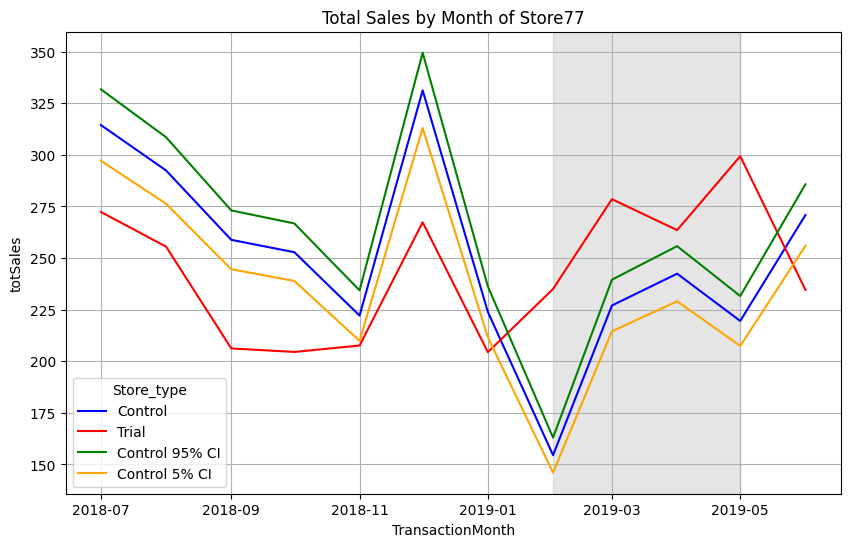

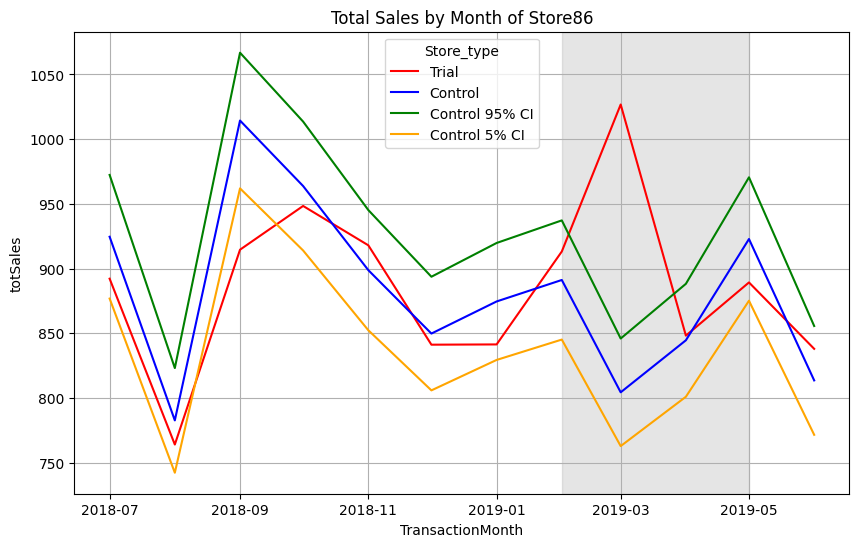

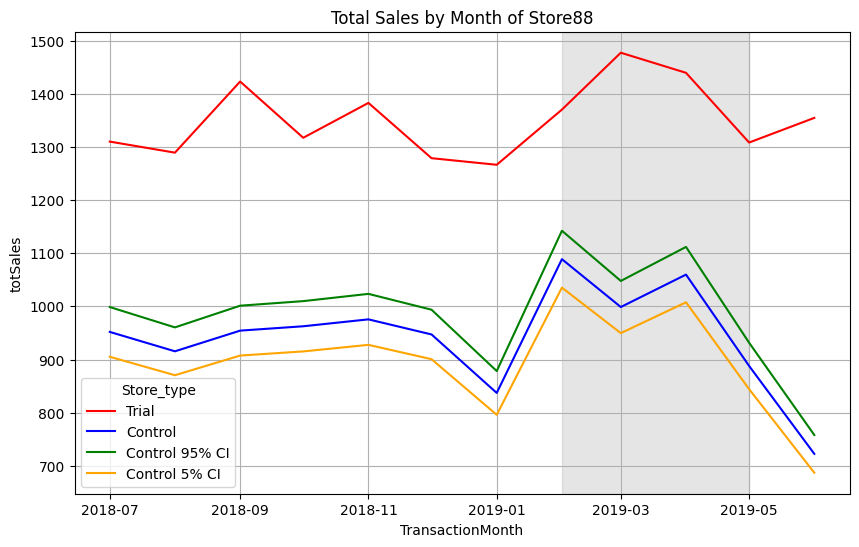

In [18]:
def plot_sales_confidence_interval(
    measureOverTime,
    trial_store,
    control_store,
    std_dev,
    trial_start=201902,
    trial_end=201905
):

    plot_data = measureOverTime.copy()

    plot_data["Store_type"] = np.where(
        plot_data["STORE_NBR"] == trial_store, "Trial",
        np.where(plot_data["STORE_NBR"] == control_store, "Control", "Other")
    )

    plot_data = plot_data[plot_data["Store_type"].isin(["Trial", "Control"])]

    plot_data["TransactionMonth"] = pd.to_datetime(
        plot_data["YEARMONTH"].astype(str) + "01"
    )

    control = plot_data[plot_data["Store_type"] == "Control"].copy()

    control_95 = control.copy()
    control_95["totSales"] *= (1 + std_dev * 2)
    control_95["Store_type"] = "Control 95% CI"

    control_5 = control.copy()
    control_5["totSales"] *= (1 - std_dev * 2)
    control_5["Store_type"] = "Control 5% CI"

    final_plot = pd.concat([plot_data, control_95, control_5])

    plt.figure(figsize=(10,6))

    plt.axvspan(
        pd.to_datetime(f"{trial_start}01"),
        pd.to_datetime(f"{trial_end}01"),
        color="grey",
        alpha=0.2
    )
    colors={"Trial": "red",
            "Control": "Blue",
            "Control 95% CI":"Green",
            "Control 5% CI": "orange"}

    sns.lineplot(
        data=final_plot,
        x="TransactionMonth",
        y="totSales",
        hue="Store_type",
        palette=colors
    )

    plt.title("Total Sales by Month of Store" + str(trial_store))
    plt.grid(True)
    plt.show()


plot_sales_confidence_interval(
    measureOverTime,
    trial_store=77,
    control_store=control_77,
    std_dev=perc_diff_77[perc_diff_77["YEARMONTH"] < 201902]["percentageDiff"].std()
)
plot_sales_confidence_interval(
    measureOverTime,
    trial_store=86,
    control_store=control_86,
    std_dev=perc_diff_86[perc_diff_86["YEARMONTH"] < 201902]["percentageDiff"].std()
)
plot_sales_confidence_interval(
    measureOverTime,
    trial_store=88,
    control_store=control_88,
    std_dev=perc_diff_88[perc_diff_88["YEARMONTH"] < 201902]["percentageDiff"].std()
)


In [19]:
def scale_control_customers(
    preTrialMeasures,
    measureOverTime,
    trial_store,
    control_store
):

    scaling_factor = (
        preTrialMeasures.loc[
            preTrialMeasures["STORE_NBR"] == trial_store, "nCustomers"
        ].sum()
        /
        preTrialMeasures.loc[
            preTrialMeasures["STORE_NBR"] == control_store, "nCustomers"
        ].sum()
    )

    scaled_control = (
        measureOverTime[measureOverTime["STORE_NBR"] == control_store]
        .assign(controlCustomers=lambda x: x["nCustomers"] * scaling_factor)
    )

    return scaled_control

cust_scaled_control_77 = scale_control_customers(
    preTrialMeasures, measureOverTime, trial_store=77, control_store=control_77
)
cust_scaled_control_86 = scale_control_customers(
    preTrialMeasures, measureOverTime, trial_store=86, control_store=control_86)
cust_scaled_control_88 = scale_control_customers(
    preTrialMeasures, measureOverTime, trial_store=88, control_store=control_88)


In [20]:
def calculate_customer_percentage_diff(
    measureOverTime,
    scaled_control,
    trial_store
):

    trial_customers = measureOverTime[
        measureOverTime["STORE_NBR"] == trial_store
    ][["YEARMONTH", "nCustomers"]]

    percentage_diff = scaled_control.merge(
        trial_customers,
        on="YEARMONTH",
        how="inner"
    )

    percentage_diff["percentageDiff"] = (
        abs(
            percentage_diff["controlCustomers"]
            - percentage_diff["nCustomers_y"]
        )
        / percentage_diff["controlCustomers"]
    )

    return percentage_diff
cust_perc_diff_77 = calculate_customer_percentage_diff(
    measureOverTime, cust_scaled_control_77, 77)
cust_perc_diff_86 = calculate_customer_percentage_diff(
    measureOverTime, cust_scaled_control_86, 86)
cust_perc_diff_88 =calculate_customer_percentage_diff(
    measureOverTime, cust_scaled_control_88, 88)


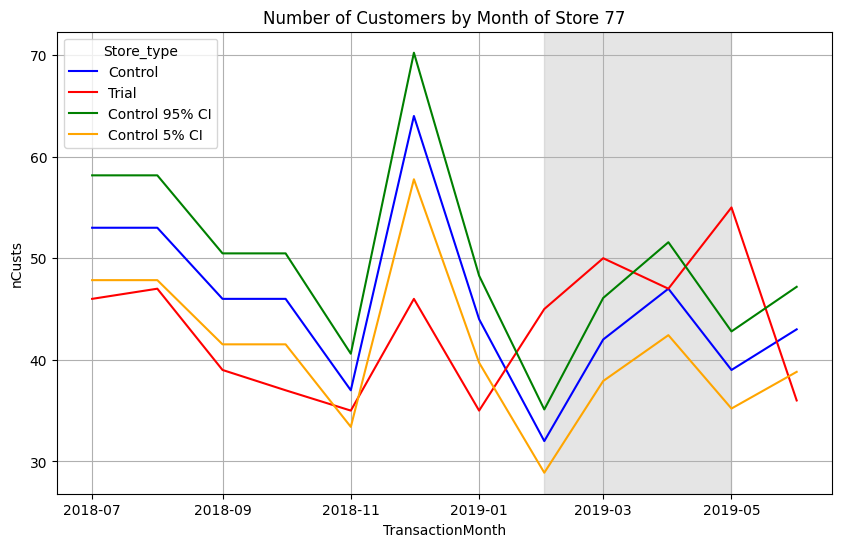

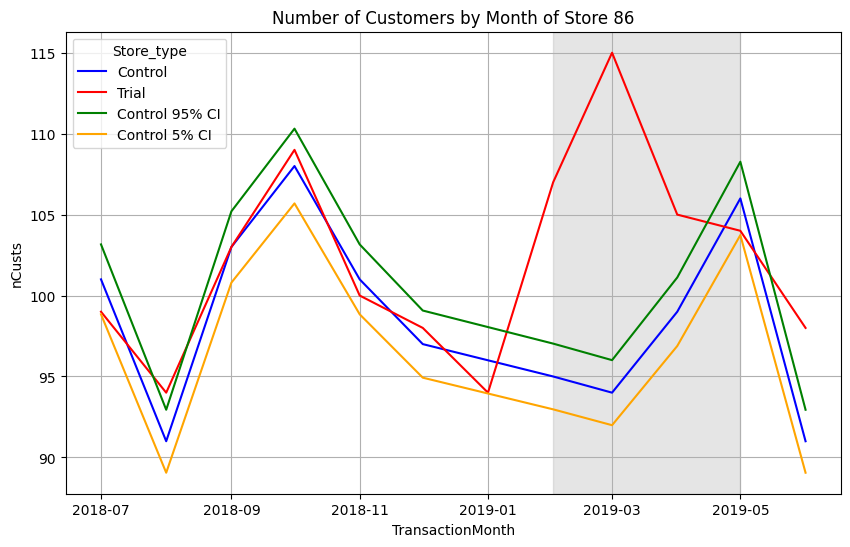

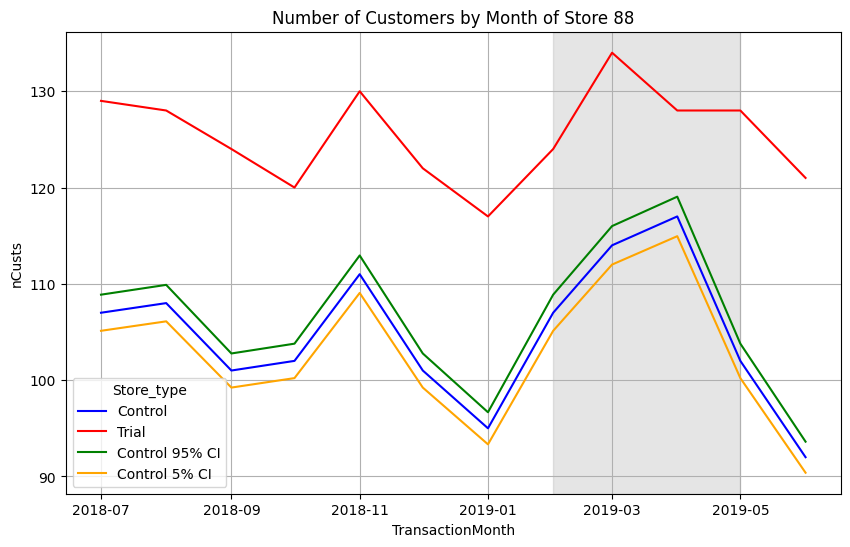

In [21]:
def plot_customer_confidence_interval(
    measureOverTime,
    trial_store,
    control_store,
    std_dev,
    trial_start=201902,
    trial_end=201905
):

    plot_data = measureOverTime.copy()

    plot_data["Store_type"] = np.where(
        plot_data["STORE_NBR"] == trial_store, "Trial",
        np.where(plot_data["STORE_NBR"] == control_store, "Control", "Other")
    )

    plot_data = plot_data[plot_data["Store_type"].isin(["Trial", "Control"])]

    plot_data["TransactionMonth"] = pd.to_datetime(
        plot_data["YEARMONTH"].astype(str) + "01"
    )

    plot_data = (
        plot_data
        .groupby(["TransactionMonth", "Store_type"], as_index=False)
        .agg(nCusts=("nCustomers", "mean"))
    )

    control = plot_data[plot_data["Store_type"] == "Control"]

    control_95 = control.copy()
    control_95["nCusts"] *= (1 + std_dev * 2)
    control_95["Store_type"] = "Control 95% CI"

    control_5 = control.copy()
    control_5["nCusts"] *= (1 - std_dev * 2)
    control_5["Store_type"] = "Control 5% CI"

    final_plot = pd.concat([plot_data, control_95, control_5])

    plt.figure(figsize=(10,6))

    plt.axvspan(
        pd.to_datetime(f"{trial_start}01"),
        pd.to_datetime(f"{trial_end}01"),
        color="grey",
        alpha=0.2
    )
    colors={"Trial": "red",
            "Control": "Blue",
            "Control 95% CI":"Green",
            "Control 5% CI": "orange"}

    sns.lineplot(
        data=final_plot,
        x="TransactionMonth",
        y="nCusts",
        hue="Store_type",
        palette=colors
    )

    plt.title("Number of Customers by Month of Store "+str(trial_store))
    plt.grid(True)
    plt.show()

plot_customer_confidence_interval(
    measureOverTime,
    trial_store=77,
    control_store=control_77,
    std_dev=cust_perc_diff_77[cust_perc_diff_77["YEARMONTH"] < 201902]["percentageDiff"].std()
)
plot_customer_confidence_interval(
    measureOverTime,
    trial_store=86,
    control_store=control_86,
    std_dev=cust_perc_diff_86[cust_perc_diff_86["YEARMONTH"] < 201902]["percentageDiff"].std()
)

plot_customer_confidence_interval(
    measureOverTime,
    trial_store=88,
    control_store=control_88,
    std_dev=cust_perc_diff_88[cust_perc_diff_88["YEARMONTH"] < 201902]["percentageDiff"].std()
)




**Conclusion – Store Trial Performance Evaluation**

The store layout trial demonstrated varying levels of effectiveness across the three trial stores, highlighting the importance of targeted, data-driven rollouts rather than a blanket implementation. Using a robust control-store methodology based on pre-trial similarity, we compared trial stores against their respective controls on key performance metrics including total sales and customer count. Stores 77 and 88 showed a statistically significant uplift in performance during the trial period, with trial store sales consistently exceeding the 95% confidence interval of their control stores for at least two of the three trial months. This uplift was primarily driven by an increase in the number of purchasing customers, indicating that the new layout successfully improved product visibility and customer engagement rather than simply increasing basket size.

In contrast, Store 86 did not exhibit a statistically significant increase in total sales, despite showing a notable rise in customer traffic. This divergence suggests that while the trial may have attracted more shoppers, it did not translate into proportional revenue growth—potentially due to factors such as promotional pricing, smaller pack size purchases, or differences in store execution. Based on these findings, the trial layout should be rolled out selectively, prioritising stores with similar characteristics to Stores 77 and 88. A broader rollout without segmentation risks diluting returns and increasing operational costs. Overall, this analysis provides strong evidence that the trial layout can drive meaningful commercial impact when deployed strategically, reinforcing the value of controlled experimentation in retail decision-making.